<a href="https://colab.research.google.com/github/wadeyman/Generative-Adversarial-Model-WGAN-GP/blob/main/WGAN_GP_on_kaggle_Anime_Face_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! kaggle datasets download -d splcher/animefacedataset

In [ ]:
! unzip animefacedataset.zip

In [ ]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import ops as KerasTensor
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
image_path = '/content/images'
images = [os.path.join(image_path, i) for i in os.listdir(image_path)]
images[:2]

['/content/images/53459_2016.jpg', '/content/images/11597_2005.jpg']

In [33]:
MODEL_NAME = 'WGAN-GP'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", "WGAN", "train_data")
TARGET_IMG_SIZE = 64
BATCH_SIZE = 256 ## tune
NOISE_DIM = 100
LAMBDA = 10 # for gradient penalty

EPOCHS = 70 ## tune
CURRENT_EPOCH = 1
SAVE_EVERY_N_EPOCHS = 15

N_CRITIC = 3
LR = 1e-4
MIN_LR = 0.000001
DECAY_FACTOR = 1.00004

In [28]:
list_ds= tf.data.Dataset.list_files(images)
for f in list_ds.take(5):
  print(f.numpy())

b'/content/images/27647_2009.jpg'
b'/content/images/20211_2007.jpg'
b'/content/images/33084_2011.jpg'
b'/content/images/60508_2018.jpg'
b'/content/images/24216_2008.jpg'


In [30]:
# Shuffle the dataset
list_ds = list_ds.shuffle(buffer_size=len(images), seed=42)  # Buffer size should be the size of the dataset

# Take only the first 6400 images
list_ds = list_ds.take(6400)
list_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=6400>

In [ ]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image - 127.5) / 127.5
  return image

def preprocess_image(file_path):
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels = 3)
  images = tf.image.resize(images, (TARGET_IMG_SIZE, TARGET_IMG_SIZE),
                           method = 'bicubic', antialias = True)
  images = normalize(images)
  return images

In [ ]:
train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE)

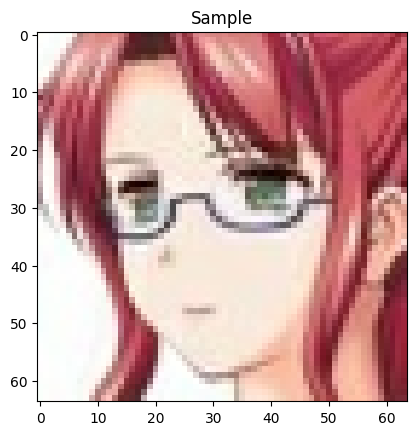

In [ ]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0 , 1 ), )

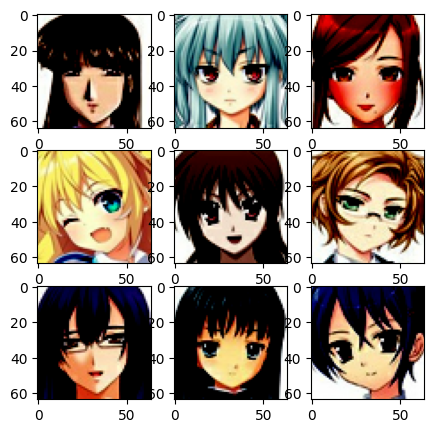

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (5,5))
sample = train_data.unbatch().take(9)
sample = [img for img in sample]
idx = 0
for row in range(3):
  for col in range(3):
    axes[row, col].imshow(sample[idx])
    idx += 1

In [ ]:
test = train_data.take(1)
test

<_TakeDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
def generator(input_z_shape = (NOISE_DIM,)):
  # convolutional
  input = Input(input_z_shape)

  # first layer
  z = Dense(4 * 4 * 512, use_bias = False)(input)
  z = Reshape((4, 4, 512))(z)

  # second
  x = Conv2DTranspose(512, (4, 4), strides = (1, 1), padding = 'same', use_bias = False,
                      kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(z)
  x = BatchNormalization()(x) # normalises the inputs of this layer acrossthe batch dimension = 128
  # normalize the output by the equation
  x = LeakyReLU()(x)

  # third
  x = Conv2DTranspose(256, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
                      kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  # fourth
  x = Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
                      kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  # fifth
  x = Conv2DTranspose(64, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
                      kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  output = Conv2DTranspose(3, (4,4), strides = (2, 2), padding= 'same', use_bias = False,
                           kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  model = Model(inputs = input, outputs=output)
  return model

def discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
  ''' critic for WGAN architecture'''
  input_x_layer = Input(input_x_shape)

  x = Conv2D(64, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
              kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(input_x_layer)
  x = LeakyReLU()(x)

  x = Conv2D(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
              kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  x = LeakyReLU()(x)

  x = Conv2D(256, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
              kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  x = LeakyReLU()(x)

  x = Conv2D(512, (4, 4), strides = (2, 2), padding = 'same', use_bias = False,
              kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)
  x = LeakyReLU()(x)

  x = Conv2D(1, (4, 4), strides=(1,1), padding = 'same', use_bias = False,
              kernel_initializer=RandomNormal(mean =0.0, stddev=0.02))(x)

  x = Flatten()(x)
  output = Dense(1, use_bias=False)(x) ## this is a big issue,
  # bias term gradient not calc if u miss out in gradient tape
  model = Model(inputs = input_x_layer, outputs = output)
  return model


In [ ]:
from keras.utils import plot_model
generator1 = generator()
generator1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │       4,194,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,072 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,772,928 (29.65 MB)

 Trainable params: 7,771,008 (29.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
#plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
discriminator1 = discriminator()
discriminator1.summary()
# plot_model(discriminator, show_shapes=True, dpi=64)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,792 (10.54 MB)

 Trainable params: 2,763,792 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
d_optimizer = Adam(learning_rate= LR, beta_1=0.5)
g_optimizer = Adam(learning_rate= LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor= DECAY_FACTOR):
  '''
  calculate new learn rate using decay factor
  '''
  new_lr = max(current_lr / decay_factor, MIN_LR) # the floor learn rate is the lowest it will go
  # if the new lr is lower than minimum, choose the min
  return new_lr

def set_learning_rate(new_lr):
  d_optimizer.learning_rate.assign(new_lr)
  g_optimizer.learning_rate.assign(new_lr)
## because keras3 deprecated backend.set_value


In [ ]:
type(discriminator1)

keras.src.models.functional.Functional

**Setup Checkpoints**

for visibility, tracing, continue training

In [ ]:
checkpoint_path = os.path.join('checkpoints', 'tensorflow', MODEL_NAME)
ckpt = tf.train.Checkpoint(generator1=generator1,
                           discriminator1=discriminator1,
                           g_optimizer=g_optimizer,
                           d_optimizer=d_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint: # if is true latest checkpoint exists
  ckpt.restore(ckpt_manager.latest_checkpoint)
  latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCHS
  print(f'Latest checkpoint epoch {CURRENT_EPOCH} restored!!')


In [ ]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12, 6),
                             subplot=(3,6), save=True, is_flatten=False):
  predictions = model.predict(test_input)
  if is_flatten:
    predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32')
  fig = plt.figure(figsize=figure_size)
  for i in range(predictions.shape[0]):
    axs = plt.subplot(subplot[0], subplot[1], i+1)
    plt.imshow(predictions[i] * 0.5 + 0.5)
    plt.axis('off')

  if save:
    plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


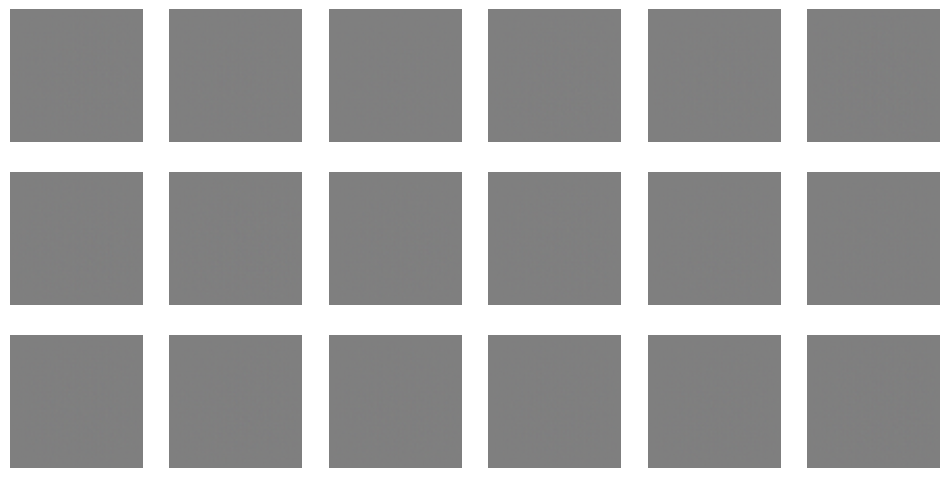

In [ ]:
num_ex_togen = 18

# reuse this seed
sample_noise = tf.random.normal([num_ex_togen, NOISE_DIM])
generate_and_save_images(generator1, 0, [sample_noise], save=False) # this sample should show bad images

![alt_text](https://blog.paperspace.com/content/images/2021/11/image-10.png)

In [ ]:
# Define the directory for TensorBoard logs
log_dir = "logs/"

# Create a file writer for TensorBoard
file_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
  '''
  one discriminator training step
  '''
  print('retrace')
  noise = tf.random.normal([batch_size, NOISE_DIM])
  epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)

# useful for creating and training machine learning models, where you need to compute gradients of loss functions with respect to model parameters
  with tf.GradientTape(persistent=True) as d_tape:
    with tf.GradientTape() as gp_tape:

      # this portion is to calculate the wasserstein loss for
      fake_image = generator1([noise], training = True)
      # since we training discriminator, need to mix a batch of real and fakes first
      fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
      fake_mixed_pred = discriminator1([fake_image_mixed], training = True) # gets the score of the image

      # compute gradient penalty
    grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed) # get gradient of predictions wrt to mixed images
    grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis = [1,2,3])) # L2 norm
    gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1.))

    fake_pred = discriminator1([fake_image], training = True)
    real_pred = discriminator1([real_image], training = True)

    D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty

    # calculate gradient for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator1.trainable_variables)

    ## these are check lines
    # print(f"Real image shape: {real_image.shape}")
    # print(f"Fake image shape: {fake_image.shape}")
    # print(f"Mixed image shape: {fake_image_mixed.shape}")

    # for grad, var in zip(D_gradients, discriminator1.trainable_variables):
    #    print(f"Gradient shape: {grad.shape}, Variable shape: {var.shape}, Gradient dtype: {grad.dtype}, Variable dtype: {var.dtype}")
    # apply th gradients to optimizer
    d_optimizer.apply_gradients(zip(D_gradients, discriminator1.trainable_variables))

    # write loss to tensorboard
    if step % 10 == 0:
      with file_writer.as_default():
        tf.summary.scalar('d_loss', tf.reduce_mean(D_loss), step=step)


In [ ]:
@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
  '''
  one generator STEP, because we need to tune the ratio of G vs D training per epoch
  '''
  print('retrace')
  noise = tf.random.normal([batch_size, NOISE_DIM])

  with tf.GradientTape() as g_tape:
    fake_image = generator1([noise], training = True)
    fake_pred = discriminator1([fake_image], training = True)
    G_loss = -tf.reduce_mean(fake_pred)

    # calculate gradient for generator to produce better fakes
    G_gradients = g_tape.gradient(G_loss, generator1.trainable_variables)
    # apply back to optimizer
    g_optimizer.apply_gradients(zip(G_gradients, generator1.trainable_variables))

    if step % 10 == 0:
      with file_writer.as_default():
        tf.summary.scalar('g_loss', tf.reduce_mean(G_loss), step=step)

In [ ]:
current_learning_rate = LR
trace = True
n_critic_count = 0

for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
  start = time.time()
  print(f'Start of epoch {epoch}')
  current_learning_rate = learning_rate_decay(current_learning_rate)
  print(f'current_learning_rate {current_learning_rate:.6f}')
  set_learning_rate(current_learning_rate)

  for step, (image) in enumerate(train_data):
    current_batch_size = image.shape[0] ## gives the batch size 128
    # train critic
    WGAN_GP_train_d_step(image, batch_size=current_batch_size,
                         step = step)
    #train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE) --> gives 128 each time
    n_critic_count += 1
    if n_critic_count % N_CRITIC == 0: # means when the critic trains every 3 times, train gen 1 once
      WGAN_GP_train_g_step(image, batch_size=current_batch_size,
                         step = step)
      n_critic_count = 0

    if step % 10 == 0:
      print('.', end='')
# Clear jupyter notebook cell output
  clear_output(wait=True)
  # Using a consistent sample so that the progress of the model is clearly visible.
  generate_and_save_images(generator1, epoch, [sample_noise], save = True)

  if epoch % SAVE_EVERY_N_EPOCHS == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')
  print('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))

ckpt_save_path = ckpt_manager.save()
print(f'Saving checkpoint for epoch {EPOCHS} at {ckpt_save_path}')

Start of epoch 1
current_learning_rate 0.000100
retrace
batch size: 128
.retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
retrace
batch size: 128
retrace
batch size: 128


retrace
batch size: 128


retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
.retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace


retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace


retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
.retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
.retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
.retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
.retrace
batch size: 128
retrace
batch size: 128
retrace
batch size: 128
retrace
retrace
batch size: 128
retrace
batc

KeyboardInterrupt: 

In [ ]:
###
# 64000 samples in dataset
# - cut to 6400 first
# - cut epoch half to 50
# - increase batch size by double
###

Credits:

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

https://www.kaggle.com/datasets/splcher/animefacedataset

https://blog.paperspace.com/wgans/

https://blog.paperspace.com/tag/neural-network/